# Дисбаланс классів. Класифікація. Кодування

---
<a name="0"/>

### Зміст:

* 1. [Класифікація датасету](#1)
    * 1.1. [Імпорт даних](#1.1)
    * 1.2. [Первинний аналіз](#1.2)
    * 1.3. [Фіча інжинірінг](#1.3)
    * 1.4. [Маштабування фіч](#1.4)
    * 1.5. [Поділ датасету на train, test](#1.5)
    * 1.6. [Тренування базової моделі(гіперпараметри=дефолтні)](#1.6)
    * 1.7. [Підбір гіперпараметрів](#1.7)
    * 1.8. [Оцінка результатів](#1.8)
* 2. [Кодування датасету](#2)

Встановлення бібліотек

In [1]:
!pip install category_encoders
!pip install -U imbalanced-learn

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/1f/e2/495811f12b2e90753fff0e42a07adb0370a725de17cc23a579ac9d3ca67c/category_encoders-2.6.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/81.8 kB ? eta -:--:--
   -------------------- ------------------- 41.0/81.8 kB 960.0 kB/s eta 0:00:01
   ---------------------------------------- 81.8/81.8 kB 1.5 MB/s eta 0:00:00
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ------------ --------------------------- 71.7/235.6 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 225.3/235.6 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 2.1 MB/s eta 0:00:00
  Attempting uninstal

Імпортування бібліотек

In [78]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import (SMOTE, SMOTENC, SMOTEN, ADASYN,
                                    BorderlineSMOTE, KMeansSMOTE, SVMSMOTE)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

Загальні налаштування

In [79]:
# Налаштуваня візуалізація
sns.set()
%config InlineBackend.figure_format = 'svg'

# Ігнорування помилок при побудові моделі
warnings.filterwarnings("ignore")

---
<a name="1"/>

## 1. Класифікація датасету
[зміст](#0)

**Ціль:** Усунення дисбалансу класів та перевірка впливу на точність моделі. <br>
**Виконання:** Отримати score для несбалансованих класів, а далі обрати стратегію балансуваня: видалення або збільшення. І з новими даними отримати score. Порівняти результати.

---
<a name="1.1"/>

### 1.1. Імпорт даних
[зміст](#0)

In [80]:
url = 'https://archive.ics.uci.edu/static/public/42/glass+identification.zip'

In [81]:
resp = urlopen(url)
myzip = ZipFile(BytesIO(resp.read()))
with myzip.open('glass.data') as myfile:
    glass_data = pd.read_csv(myfile, delimiter=',',
                             names=['Id_number', 'RI', 'Na',
                                    'Mg', 'Al','Si', 'K',
                                    'Ca', 'Ba', 'Fe',
                                    'Type_of_glass'])

In [82]:
glass_data.head()

,Id_number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Опис фіч та таргету датасету:

| Назва фічі |Опис|Тип|
|--- |--- |---
|Id_number| Ідентифікаційний номер: від 1 до 214|
| RI | показник заломлення| Кількисний
| Na | натрій (одиниця вимірювання: ваговий відсоток у відповідному оксиді, як і для інших хім елементів) | Кількисний
| Mg |магній | Кількисний
| Al |алюміній | Кількисний
| Si |Кремній | Кількисний
| K  |Калій | Кількисний
| Ca |Кальцій | Кількисний
| Ba |Барій | Кількисний
| Fe |Залізо | Кількисний
| Type_of_glass | Тип скла | Категорыальный (target)

Таблиця типів скла

| Тип |Опис|
|--- |---
|1| вікна будівель оброблено з плаваючим курсором
|2| вікна будівель не оброблені з плаваючою точкою
|3| вікна транспортних засобів оброблені з флоат-обробкою
|4| вікна транспортних засобів, не оброблені (немає в цій базі даних)
|5| контейнери
|6| посуд
|7| фари


---
<a name="1.2"/>

### 1.2. Первинний аналіз
[зміст](#0)

Перевірка дублікатів

In [83]:
glass_data.duplicated().sum()

0

In [84]:
glass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id_number      214 non-null    int64  
 1   RI             214 non-null    float64
 2   Na             214 non-null    float64
 3   Mg             214 non-null    float64
 4   Al             214 non-null    float64
 5   Si             214 non-null    float64
 6   K              214 non-null    float64
 7   Ca             214 non-null    float64
 8   Ba             214 non-null    float64
 9   Fe             214 non-null    float64
 10  Type_of_glass  214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [85]:
glass_data.describe(include='all')

,Id_number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Подивимость на баланс класів

In [86]:
glass_data['Type_of_glass'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type_of_glass, dtype: int64

Висновок з первинного аналізу: Дані без пропусків, для деяких фіч, таких як Mg, K, Ba, Fe э значеня 0, але вони відображають 0 вміст речовини до складу скла, це нормально. В датасеті присутній дисбаланс класів в таргеті Type_of_glass. Данних мало, усього лише 214 рядків, тому оберемо стратегію збільшеня екземлярів для усуненя дисбалансу класів.

---
<a name="1.3"/>

### 1.3. Фіча інжинірінг
[зміст](#0)

Для отримання найкращій результат протестуємо одразу декілька методів Over-samplig: SMOTE, SMOTENC, SMOTEN, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTEENN, SMOTETomek. Запишемо результати в таблицю та порівняємо їх ефективність. <br>

Видалемо рядок Id_number так як він не несе ніякої корисної інформація для навчання.

In [87]:
glass_data = glass_data.drop('Id_number', axis=1)

Подивимось на росподіл фіч

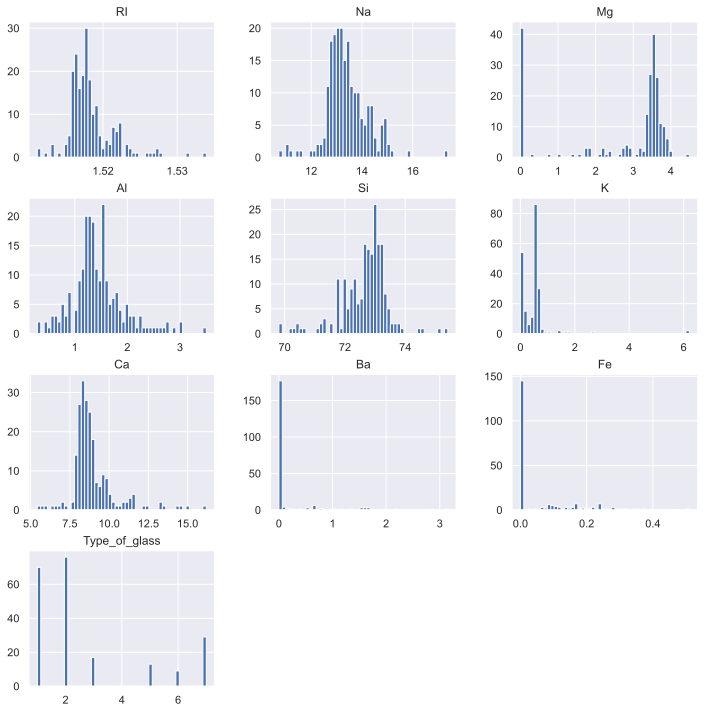

In [88]:
glass_data.hist(bins=50, figsize=(12, 12))
plt.show()

Бачимо що фічі RI, Na, Al, Si, близьці до нормального росподілу. Mg має багато екземплярів 0, що зміщює графік вправо. Fe та Ba виглядають як бінарні значеня, багато екземплярів 0 та мало інших. Можливо їх треба перетворити в {0;1}. K має викид що зміщює графік вліво.

Подивимось на кореляцію фіч одна-з-одною та з таргетом за допомогою `heatmap()`

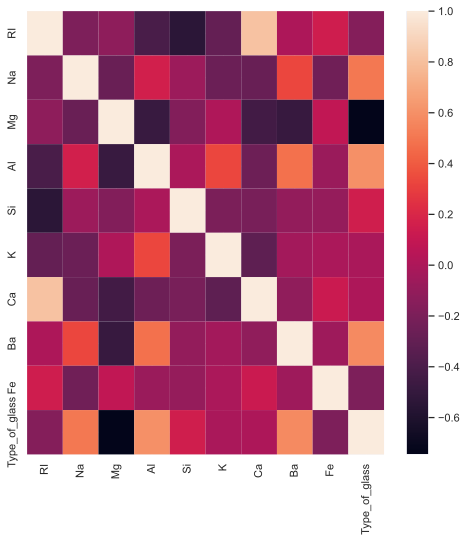

In [89]:
sns.set (rc = {'figure.figsize':(8, 8)})
corr_matrix = glass_data.corr()
sns.heatmap(corr_matrix);

Виходячи з графіка не спостерегаєтся сильної кореляції фіч одна з одною та таргетом, можливо тільки Ca корелює з RI. Але з іншими фічами вони не так добре корелюють, тому спробуємо побудувати моделі не видаляючі фічі.

Перетворня Ba та Fe в бінарну фічу

In [90]:
def get_binery(value):
    if value == 0.0:
        return 0
    else:
        return 1

In [91]:
glass_data['Ba'] = glass_data['Ba'].map(lambda x : get_binery(x))
glass_data['Fe'] = glass_data['Fe'].map(lambda x : get_binery(x))

In [92]:
glass_data[['Ba','Fe']].value_counts()

Ba  Fe
0   0     120
    1      56
1   0      24
    1      14
dtype: int64

---
<a name="1.4"/>

### 1.4. Маштабування фіч
[зміст](#0)

Сплітимо датасети на фічі та таргет.

In [93]:
X = glass_data.drop('Type_of_glass', axis=1).values
y = glass_data['Type_of_glass'].copy().values

Маштабуємо фічі зо допомогою скалєра `MinMaxScaler()`

In [94]:
# Для некодованого датасету
X_scaled = MinMaxScaler().fit_transform(X)

---
<a name="1.5"/>

### 1.5. Поділ датасету на train, test
[зміст](#0)

Ділимо датасет на train та test. Не будемо роботи valid, тому що данних дуже мало.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=17)

Балансування класів. Використаємо такі балансери: SMOTE, ADASYN, SMOTETomek <br>

In [96]:
# Вхідне значені
np.unique(y_train, return_counts=True)

(array([1, 2, 3, 5, 6, 7], dtype=int64),
 array([54, 51,  9,  9,  7, 19], dtype=int64))

In [97]:
# Застосовуємо балансер SMOTE()
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Перевіряємо результат
np.unique(y_train_sm, return_counts=True)

(array([1, 2, 3, 5, 6, 7], dtype=int64),
 array([54, 54, 54, 54, 54, 54], dtype=int64))

Відбалансовано в рівному співвідношені.



In [98]:
# Застосовуємо балансер ADASYN()
ada = ADASYN(random_state=42, sampling_strategy='minority')
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

# Перевіряємо результат
np.unique(y_train_ada, return_counts=True)

(array([1, 2, 3, 5, 6, 7], dtype=int64),
 array([54, 51,  9,  9, 54, 19], dtype=int64))

Відбалансован найменший клас, став найбільним.

In [99]:
# Застосовуємо балансер SMOTETomek()
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# Перевіряємо результат
np.unique(y_train_smt, return_counts=True)

(array([1, 2, 3, 5, 6, 7], dtype=int64),
 array([52, 51, 54, 54, 54, 53], dtype=int64))

Відбалансувало майже однаково, з різницею між класами в один екземпляр.

---
<a name="1.6"/>

### 1.6. Тренування базової моделі(гіперпараметри=дефолтні)
[зміст](#0)

Натренеруємо базову модель за допомогою KNeighborsClassifier()

Створимо функцію тренуваня базової моделі

In [100]:
def kNN_model_default(X_train, y_train, X_test):
    kNN = KNeighborsClassifier()
    kNN = kNN.fit(X_train, y_train)

    y_predict = kNN.predict(X_test)

    return y_predict

In [101]:
# Отримаємо предикт
# Без балансера
y_predict_default_nb = kNN_model_default(X_train, y_train, X_test)
# Для SMOTE()
y_predict_default_sm = kNN_model_default(X_train_sm, y_train_sm, X_test)
# Для ADASYN()
y_predict_default_ada = kNN_model_default(X_train_ada, y_train_ada, X_test)
# Для SMOTETomek()
y_predict_default_smt = kNN_model_default(X_train_smt, y_train_smt, X_test)

---
<a name="1.7"/>

### 1.7. Підбір гіперпараметрів
[зміст](#0)

Підберемо оптимальні гіперпараметри за допомогою GridSearchCV()

Створимо функцію підбору гіперпараметрів

In [102]:
def kNN_model_best(X_train, y_train, X_test):
    kNN_parameters = {'n_neighbors':[5,8,10,15,25,50],
                  'weights':    ('uniform','distance'),
                  'algorithm':  ('auto', 'ball_tree', 'kd_tree', 'brute'),
                  'p':          [1,2,3,4]}
    kNN = KNeighborsClassifier()
    kNN_bp = GridSearchCV(kNN, kNN_parameters)
    kNN_bp = kNN_bp.fit(X_train, y_train)

    y_predict = kNN_bp.predict(X_test)

    return y_predict, kNN_bp.best_params_

In [103]:
# Натренеруэмо бля різних балансерів
# Без балансера
y_predict_bp_nb, bp_nb = kNN_model_best(X_train, y_train, X_test)
# Для SMOTE()
y_predict_bp_sm, bp_sm = kNN_model_best(X_train_sm, y_train_sm, X_test)
# Для ADASYN()
y_predict_bp_ada, bp_ada = kNN_model_best(X_train_ada, y_train_ada, X_test)
# Для SMOTETomek()
y_predict_bp_smt, bp_smt = kNN_model_best(X_train_smt, y_train_smt, X_test)

---
<a name="1.8"/>

### 1.8. Оцінка результатів
[зміст](#0)

Для оцінки результатів навчання моделей з різними балансерами класів скористуємось classification_report_imbalanced()

#### Балансер - Відсутній

In [104]:
print("Балансер: Відсутній - Модель: KNeighborsClassifier() - гіперпараметри: default ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_default_nb))

Балансер: Відсутній - Модель: KNeighborsClassifier() - гіперпараметри: default 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.52      0.88      0.73      0.65      0.80      0.65        16
          2       0.79      0.76      0.88      0.78      0.82      0.66        25
          3       0.00      0.00      1.00      0.00      0.00      0.00         8
          5       0.33      0.25      0.97      0.29      0.49      0.22         4
          6       1.00      0.50      1.00      0.67      0.71      0.48         2
          7       0.90      0.90      0.98      0.90      0.94      0.88        10

avg / total       0.62      0.68      0.88      0.64      0.71      0.58        65



In [105]:
print(f"Балансер: Відсутній - Модель: KNeighborsClassifier() - гіперпараметри: {bp_nb} ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_bp_nb))

Балансер: Відсутній - Модель: KNeighborsClassifier() - гіперпараметри: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.52      0.81      0.76      0.63      0.78      0.62        16
          2       0.75      0.72      0.85      0.73      0.78      0.60        25
          3       0.00      0.00      1.00      0.00      0.00      0.00         8
          5       0.67      0.50      0.98      0.57      0.70      0.47         4
          6       0.50      0.50      0.98      0.50      0.70      0.47         2
          7       0.91      1.00      0.98      0.95      0.99      0.98        10

avg / total       0.61      0.68      0.88      0.64      0.71      0.58        65



#### Балансер - SMOTE()

In [106]:
print("Балансер: SMOTE() - Модель: KNeighborsClassifier() - гіперпараметри: default ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_default_sm))

Балансер: SMOTE() - Модель: KNeighborsClassifier() - гіперпараметри: default 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.75      0.94      0.90      0.83      0.92      0.85        16
          2       0.95      0.72      0.97      0.82      0.84      0.68        25
          3       0.50      0.50      0.93      0.50      0.68      0.44         8
          5       0.67      0.50      0.98      0.57      0.70      0.47         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       0.91      1.00      0.98      0.95      0.99      0.98        10

avg / total       0.81      0.78      0.95      0.78      0.86      0.74        65



In [107]:
print(f"Балансер: SMOTE() - Модель: KNeighborsClassifier() - гіперпараметри: {bp_sm} ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_bp_sm))

Балансер: SMOTE() - Модель: KNeighborsClassifier() - гіперпараметри: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.68      0.81      0.88      0.74      0.84      0.71        16
          2       0.86      0.76      0.93      0.81      0.84      0.69        25
          3       0.50      0.50      0.93      0.50      0.68      0.44         8
          5       0.67      0.50      0.98      0.57      0.70      0.47         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       1.00      0.90      1.00      0.95      0.95      0.89        10

avg / total       0.77      0.75      0.93      0.76      0.83      0.69        65



#### Балансер - ADASYN()

In [108]:
print("Балансер: ADASYN() - Модель: KNeighborsClassifier() - гіперпараметри: default ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_default_ada))

Балансер: ADASYN() - Модель: KNeighborsClassifier() - гіперпараметри: default 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.52      0.88      0.73      0.65      0.80      0.65        16
          2       0.83      0.76      0.90      0.79      0.83      0.67        25
          3       0.00      0.00      1.00      0.00      0.00      0.00         8
          5       1.00      0.25      1.00      0.40      0.50      0.23         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       0.90      0.90      0.98      0.90      0.94      0.88        10

avg / total       0.66      0.69      0.89      0.65      0.72      0.60        65



In [109]:
print(f"Балансер: ADASYN() - Модель: KNeighborsClassifier() - гіперпараметри: {bp_ada} ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_bp_ada))

Балансер: ADASYN() - Модель: KNeighborsClassifier() - гіперпараметри: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.54      0.81      0.78      0.65      0.79      0.63        16
          2       0.83      0.80      0.90      0.82      0.85      0.71        25
          3       0.50      0.12      0.98      0.20      0.35      0.11         8
          5       1.00      0.50      1.00      0.67      0.71      0.48         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       1.00      0.90      1.00      0.95      0.95      0.89        10

avg / total       0.75      0.72      0.90      0.71      0.78      0.64        65



#### Балансер - SMOTETomek()

In [110]:
print("Балансер: SMOTETomek() - Модель: KNeighborsClassifier() - гіперпараметри: default ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_default_smt))

Балансер: SMOTETomek() - Модель: KNeighborsClassifier() - гіперпараметри: default 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.88      0.90      0.80      0.89      0.78        16
          2       0.89      0.68      0.95      0.77      0.80      0.63        25
          3       0.44      0.50      0.91      0.47      0.68      0.44         8
          5       0.67      0.50      0.98      0.57      0.70      0.47         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       0.91      1.00      0.98      0.95      0.99      0.98        10

avg / total       0.78      0.75      0.94      0.75      0.84      0.70        65



In [111]:
print(f"Балансер: SMOTETomek() - Модель: KNeighborsClassifier() - гіперпараметри: {bp_smt} ")
print(f"{'-'*100}")
print(classification_report_imbalanced(y_test, y_predict_bp_smt))

Балансер: SMOTETomek() - Модель: KNeighborsClassifier() - гіперпараметри: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 
----------------------------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          1       0.68      0.81      0.88      0.74      0.84      0.71        16
          2       0.90      0.72      0.95      0.80      0.83      0.67        25
          3       0.44      0.50      0.91      0.47      0.68      0.44         8
          5       0.67      0.50      0.98      0.57      0.70      0.47         4
          6       0.50      1.00      0.97      0.67      0.98      0.97         2
          7       0.90      0.90      0.98      0.90      0.94      0.88        10

avg / total       0.76      0.74      0.94      0.74      0.83      0.68        65



#### Висновок
Всі моделі видають більш-меньш схожі гарні результати. Особливо з підібраними гіперпараметрами. Окремо можно побачити що моделі без балансуваня та с балансуваням ADASYN() та без гіпераметрів не передбачають клас 3. Між тим, клас 3 не найменьший клас в початковій вибірці.
Найкращій показник мабуть в моделі з дефолтними гіперпараметрами  та балансером: SMOTE().

---
<a name="2"/>

## 2. Кодування датасету
[зміст](#0)

Імпорт датасету

In [112]:
url2 = 'https://archive.ics.uci.edu/static/public/73/mushroom.zip'

In [113]:
resp2 = urlopen(url2)
myzip2 = ZipFile(BytesIO(resp2.read()))
with myzip2.open('agaricus-lepiota.data') as myfile:
    mushroom_data = pd.read_csv(myfile, delimiter=',',
                                 names=['poisonous','cap-shape', 'cap-surface',
                                       'cap-color',
                                       'bruises?', 'odor', 'gill-attachment',
                                       'gill-spacing', 'gill-size', 'gill-color',
                                       'stalk-shape', 'stalk-root',
                                       'stalk-surface-above-ring',
                                       'stalk-surface-below-ring',
                                       'stalk-color-above-ring',
                                       'stalk-color-below-ring', 'veil-type',
                                       'veil-color', 'ring-number','ring-type',
                                       'spore-print-color', 'population',
                                       'habitat'])

In [114]:
mushroom_data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [115]:
mushroom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [116]:
mushroom_data.describe(include='all')

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Дивлячись на аналіз можна побачити що всі фічі категоріальні. Без відсутніх значень. poisonous - target.

---

#### Кодуваня

За допомогою різних енкодерів із category_encoders та sklearn.preprocessing закодуємо наші категоріальні фічі.

Імпортуємо наші інкодери

In [117]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from category_encoders import (BackwardDifferenceEncoder, BaseNEncoder,
                               BinaryEncoder, CountEncoder, GrayEncoder,
                               JamesSteinEncoder,
                               PolynomialEncoder,
                               SumEncoder, WOEEncoder)

from category_encoders import OneHotEncoder as OneHotEncoder2

Розділимо датасет на фічі та таргет

In [118]:
X = mushroom_data.drop('poisonous', axis=1).values
y = mushroom_data['poisonous'].copy().values

In [119]:
X

array([['x', 's', 'n', ..., 'k', 's', 'u'],
       ['x', 's', 'y', ..., 'n', 'n', 'g'],
       ['b', 's', 'w', ..., 'n', 'n', 'm'],
       ...,
       ['f', 's', 'n', ..., 'b', 'c', 'l'],
       ['k', 'y', 'n', ..., 'w', 'v', 'l'],
       ['x', 's', 'n', ..., 'o', 'c', 'l']], dtype=object)

In [120]:
X.shape

(8124, 22)

---

#### OneHotEncoder() sklearn

In [121]:
enc = OneHotEncoder(handle_unknown='ignore')

X_enc = enc.fit_transform(X).toarray()

In [122]:
X_enc

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
X_enc.shape

(8124, 117)

In [124]:
enc.categories_

[array(['b', 'c', 'f', 'k', 's', 'x'], dtype=object),
 array(['f', 'g', 's', 'y'], dtype=object),
 array(['b', 'c', 'e', 'g', 'n', 'p', 'r', 'u', 'w', 'y'], dtype=object),
 array(['f', 't'], dtype=object),
 array(['a', 'c', 'f', 'l', 'm', 'n', 'p', 's', 'y'], dtype=object),
 array(['a', 'f'], dtype=object),
 array(['c', 'w'], dtype=object),
 array(['b', 'n'], dtype=object),
 array(['b', 'e', 'g', 'h', 'k', 'n', 'o', 'p', 'r', 'u', 'w', 'y'],
       dtype=object),
 array(['e', 't'], dtype=object),
 array(['?', 'b', 'c', 'e', 'r'], dtype=object),
 array(['f', 'k', 's', 'y'], dtype=object),
 array(['f', 'k', 's', 'y'], dtype=object),
 array(['b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y'], dtype=object),
 array(['b', 'c', 'e', 'g', 'n', 'o', 'p', 'w', 'y'], dtype=object),
 array(['p'], dtype=object),
 array(['n', 'o', 'w', 'y'], dtype=object),
 array(['n', 'o', 't'], dtype=object),
 array(['e', 'f', 'l', 'n', 'p'], dtype=object),
 array(['b', 'h', 'k', 'n', 'o', 'r', 'u', 'w', 'y'], dtype=ob

Як бачимо для кожного унікального значеня фіч енкодер створив стовбчик, тим самим збільшив їх кількість 22 > 117. І там де фіча відповідає стовбчику ставить 1, в інших 0.

---

#### LabelEncoder()
Цех енкодер трансформує одну фічу. В нашому випадку це буде target.

In [125]:
le = LabelEncoder()

y_le = le.fit_transform(y)

In [126]:
y_le

array([1, 0, 0, ..., 0, 1, 0])

In [127]:
y_le.shape

(8124,)

Так як у нас таргет з 2 категоріями, то енкодер перетворив їх у 0 та 1.

---

#### BackwardDifferenceEncoder()

In [128]:
bd = BackwardDifferenceEncoder(drop_invariant=True)
X_bd = bd.fit_transform(X)

In [129]:
X_bd

,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,2_0,2_1,...,20_1,20_2,20_3,20_4,21_0,21_1,21_2,21_3,21_4,21_5
0,-0.833333,-0.666667,-0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,-0.9,-0.8,...,-0.666667,-0.5,-0.333333,-0.166667,-0.857143,-0.714286,-0.571429,-0.428571,-0.285714,-0.142857
1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,0.1,-0.8,...,-0.666667,-0.5,-0.333333,-0.166667,0.142857,-0.714286,-0.571429,-0.428571,-0.285714,-0.142857
2,0.166667,-0.666667,-0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,0.1,0.2,...,-0.666667,-0.5,-0.333333,-0.166667,0.142857,0.285714,-0.571429,-0.428571,-0.285714,-0.142857
3,-0.833333,-0.666667,-0.5,-0.333333,-0.166667,0.25,-0.5,-0.25,0.1,0.2,...,-0.666667,-0.5,-0.333333,-0.166667,-0.857143,-0.714286,-0.571429,-0.428571,-0.285714,-0.142857
4,-0.833333,-0.666667,-0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,0.1,0.2,...,0.333333,-0.5,-0.333333,-0.166667,0.142857,-0.714286,-0.571429,-0.428571,-0.285714,-0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.166667,0.333333,0.5,0.666667,-0.166667,-0.75,-0.5,-0.25,-0.9,-0.8,...,0.333333,0.5,0.666667,0.833333,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143
8120,-0.833333,-0.666667,-0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,-0.9,-0.8,...,0.333333,0.5,-0.333333,-0.166667,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143
8121,0.166667,0.333333,0.5,-0.333333,-0.166667,-0.75,-0.5,-0.25,-0.9,-0.8,...,0.333333,0.5,0.666667,0.833333,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143
8122,0.166667,0.333333,0.5,0.666667,-0.166667,0.25,-0.5,-0.25,-0.9,-0.8,...,0.333333,0.5,-0.333333,-0.166667,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143


BackwardDifferenceEncoder кодує за таким принципом: N ознак кодуються матрицею (N, N-1), де на головній діагоналі матриці та над неї розміщені одиниці зі знаком мінус, а одразу під головною діагоналлю йде порядковий номер значення та нижче за нього нулі. 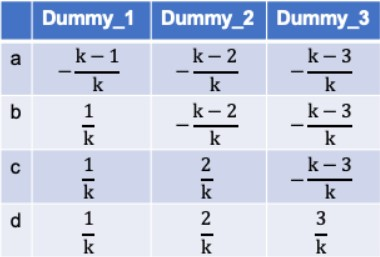<br>
Приклад кодування з 4 значенями.

---

#### BaseNEncoder()

In [130]:
bn = BaseNEncoder(base=4)
X_bn = bn.fit_transform(X)

In [131]:
X_bn

,0_0,0_1,1_0,1_1,2_0,2_1,3_0,4_0,4_1,5_0,...,16_1,17_0,18_0,18_1,19_0,19_1,20_0,20_1,21_0,21_1
0,0,1,0,1,0,1,1,0,1,1,...,1,1,0,1,0,1,0,1,0,1
1,0,1,0,1,0,2,1,0,2,1,...,1,1,0,1,0,2,0,2,0,2
2,0,2,0,1,0,3,1,0,3,1,...,1,1,0,1,0,2,0,2,0,3
3,0,1,0,2,0,3,1,0,1,1,...,1,1,0,1,0,1,0,1,0,1
4,0,1,0,1,1,0,2,1,0,1,...,1,1,0,2,0,2,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,1,0,1,0,1,2,1,0,2,...,3,1,0,1,2,1,1,2,1,3
8120,0,1,0,1,0,1,2,1,0,2,...,2,1,0,1,2,1,1,0,1,3
8121,1,0,0,1,0,1,2,1,0,2,...,3,1,0,1,2,1,1,2,1,3
8122,1,1,0,2,0,1,2,1,3,1,...,1,1,0,2,1,1,1,0,1,3


BaseNEncoder() за замовченям кодує фічу в 2х бітну. Створює стільки стовбчиків скільки потрібно для опису значеня. Параметром base можно змінити кількість бітів.

---

#### BinaryEncoder()

In [132]:
be = BinaryEncoder()
X_be = be.fit_transform(X)

In [133]:
X_be

,0_0,0_1,0_2,1_0,1_1,1_2,2_0,2_1,2_2,2_3,...,19_0,19_1,19_2,19_3,20_0,20_1,20_2,21_0,21_1,21_2
0,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
2,0,1,0,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,0,1,1
3,0,0,1,0,1,0,0,0,1,1,...,0,0,0,1,0,0,1,0,0,1
4,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,1,0,0,1,0,0,0,1,...,1,0,0,1,1,1,0,1,1,1
8120,0,0,1,0,0,1,0,0,0,1,...,1,0,0,1,1,0,0,1,1,1
8121,1,0,0,0,0,1,0,0,0,1,...,1,0,0,1,1,1,0,1,1,1
8122,1,0,1,0,1,0,0,0,0,1,...,0,1,0,1,1,0,0,1,1,1


BinaryEncoder() кодує у 2х бітну структуру.

---

#### CountEncoder()

In [134]:
ce = CountEncoder()
X_ce = ce.fit_transform(X)

In [135]:
X_ce

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,3656,2556,2284,3376,256,7914,6812,2512,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
1,3656,2556,1072,3376,400,7914,6812,5612,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,2148
2,452,2556,1040,3376,400,7914,6812,5612,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,292
3,3656,3244,1040,3376,256,7914,6812,2512,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
4,3656,2556,1840,4748,3528,7914,1312,5612,408,4608,...,4936,4464,4384,8124,7924,7488,2776,1968,384,2148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,828,2556,2284,4748,3528,210,6812,5612,86,3516,...,4936,192,192,8124,96,7488,3968,48,340,832
8120,3656,2556,2284,4748,3528,210,6812,5612,86,3516,...,4936,192,192,8124,96,7488,3968,48,4040,832
8121,3152,2556,2284,4748,3528,210,6812,5612,1048,3516,...,4936,192,192,8124,96,7488,3968,48,340,832
8122,828,3244,2284,4748,576,7914,6812,2512,1728,4608,...,2304,4464,4384,8124,7924,7488,2776,2388,4040,832


Кодування лічильників для категоріальних ознак.

Для певної категоріальної ознаки замініть назви груп кількістю груп.

---

#### GrayEncoder()

In [136]:
ge = GrayEncoder()
X_ge = ge.fit_transform(X)

In [137]:
X_ge

,0_0,0_1,0_2,1_0,1_1,1_2,2_0,2_1,2_2,2_3,...,19_0,19_1,19_2,19_3,20_0,20_1,20_2,21_0,21_1,21_2
0,1,0,1,0,1,0,0,1,1,1,...,0,0,1,0,1,1,0,1,0,1
1,1,0,1,0,1,0,1,1,1,1,...,0,1,1,0,0,1,0,0,1,1
2,0,0,1,0,1,0,1,1,0,1,...,0,1,1,0,0,1,0,1,1,0
3,1,0,1,1,1,0,1,1,0,1,...,0,0,1,0,1,1,0,1,0,1
4,1,0,1,0,1,0,0,1,1,0,...,0,1,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,1,0,0,1,0,0,1,1,1,...,0,0,0,1,0,1,1,0,1,0
8120,1,0,1,0,1,0,0,1,1,1,...,0,0,0,1,1,1,1,0,1,0
8121,0,1,0,0,1,0,0,1,1,1,...,0,0,0,1,0,1,1,0,1,0
8122,1,1,0,1,1,0,0,1,1,1,...,1,1,0,0,1,1,1,0,1,0


GrayEncoder() – це форма двійкового кодування, де послідовні значення відрізняються лише одним бітом. Отже, GrayEncoder кодування має сенс лише для порядкових ознак

---

#### JamesSteinEncoder()

Приймає біномінальний таргет. Використоаємо y після LabelEncoder()

In [138]:
js = JamesSteinEncoder()
X_js = js.fit_transform(X, y_le)

In [139]:
X_js

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.471626,0.540749,0.460301,0.184834,1.000000,0.492545,0.558426,0.885350,0.249130,0.540387,...,0.337491,0.419451,0.419255,0.482029,0.491325,0.508547,0.260305,0.200323,0.345914,0.664333
1,0.471626,0.540749,0.572354,0.184834,0.000000,0.492545,0.558426,0.301497,0.249130,0.540387,...,0.337491,0.419451,0.419255,0.482029,0.491325,0.508547,0.260305,0.193304,0.000000,0.388055
2,0.168402,0.540749,0.370146,0.184834,0.000000,0.492545,0.558426,0.301497,0.191812,0.540387,...,0.337491,0.419451,0.419255,0.482029,0.491325,0.508547,0.260305,0.193304,0.000000,0.195710
3,0.471626,0.527334,0.370146,0.184834,1.000000,0.492545,0.558426,0.885350,0.191812,0.540387,...,0.337491,0.419451,0.419255,0.482029,0.491325,0.508547,0.260305,0.200323,0.345914,0.664333
4,0.471626,0.540749,0.455703,0.693345,0.073095,0.492545,0.085366,0.301497,0.249130,0.437500,...,0.337491,0.419451,0.419255,0.482029,0.491325,0.508547,0.599651,0.193304,0.000000,0.388055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.659940,0.540749,0.460301,0.693345,0.073095,0.085714,0.558426,0.301497,0.336411,0.540387,...,0.337491,0.000000,0.000000,0.482029,0.000000,0.508547,0.260305,0.000000,0.220520,0.642465
8120,0.471626,0.540749,0.460301,0.693345,0.073095,0.085714,0.558426,0.301497,0.336411,0.540387,...,0.337491,0.000000,0.000000,0.482029,0.000000,0.508547,0.260305,0.000000,0.644160,0.642465
8121,0.490165,0.540749,0.460301,0.693345,0.073095,0.085714,0.558426,0.301497,0.191812,0.540387,...,0.337491,0.000000,0.000000,0.482029,0.000000,0.508547,0.260305,0.000000,0.220520,0.642465
8122,0.659940,0.527334,0.460301,0.693345,1.000000,0.492545,0.558426,0.885350,1.000000,0.437500,...,0.908635,0.419451,0.419255,0.482029,0.491325,0.508547,0.599651,0.670979,0.644160,0.642465


Для значення ознаки i оцінка Джеймса-Штейна повертає середнє зважене значення:

* Середнє цільове значення для спостережуваного значення ознаки i .
* Середнє цільове значення (незалежно від значення ознаки).

За формулою JS_i = (1-B)*mean(y_i) + B*mean(y)

B = var(y_i) / (var(y_i)+var(y))

---

#### OneHotEncoder() category_encoders

In [140]:
enc2 = OneHotEncoder2(handle_unknown='ignore')

X_enc2 = enc2.fit_transform(X)

In [141]:
X_enc2

,0_1,0_2,0_3,0_4,0_5,0_6,1_1,1_2,1_3,1_4,...,20_4,20_5,20_6,21_1,21_2,21_3,21_4,21_5,21_6,21_7
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8120,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8121,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8122,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [142]:
X_enc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 117 entries, 0_1 to 21_7
dtypes: int64(117)
memory usage: 7.3 MB


Працює так само як і в sklearn. Тільки результ DataFrame, значеня int

---

#### PolynomialEncoder()

In [143]:
pe = PolynomialEncoder()
X_pe = pe.fit_transform(X)

In [144]:
X_pe

,intercept,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,2_0,...,20_1,20_2,20_3,20_4,21_0,21_1,21_2,21_3,21_4,21_5
0,1,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.670820,0.5,-0.223607,-0.495434,...,0.545545,-0.372678,0.188982,-0.062994,-0.566947,5.455447e-01,-0.408248,0.241747,-0.109109,0.032898
1,1,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.670820,0.5,-0.223607,-0.385337,...,-0.109109,0.521749,-0.566947,0.314970,-0.377964,9.521795e-17,0.408248,-0.564076,0.436436,-0.197386
2,1,-0.358569,-0.109109,0.521749,-0.566947,0.314970,-0.670820,0.5,-0.223607,-0.275241,...,-0.109109,0.521749,-0.566947,0.314970,-0.188982,-3.273268e-01,0.408248,0.080582,-0.545545,0.493464
3,1,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.223607,-0.5,0.670820,-0.275241,...,0.545545,-0.372678,0.188982,-0.062994,-0.566947,5.455447e-01,-0.408248,0.241747,-0.109109,0.032898
4,1,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.670820,0.5,-0.223607,-0.165145,...,-0.436436,0.298142,0.377964,-0.629941,-0.377964,9.521795e-17,0.408248,-0.564076,0.436436,-0.197386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0.358569,-0.109109,-0.521749,-0.566947,-0.314970,-0.670820,0.5,-0.223607,-0.495434,...,0.545545,0.372678,0.188982,0.062994,0.566947,5.455447e-01,0.408248,0.241747,0.109109,0.032898
8120,1,-0.597614,0.545545,-0.372678,0.188982,-0.062994,-0.670820,0.5,-0.223607,-0.495434,...,-0.436436,-0.298142,0.377964,0.629941,0.566947,5.455447e-01,0.408248,0.241747,0.109109,0.032898
8121,1,0.119523,-0.436436,-0.298142,0.377964,0.629941,-0.670820,0.5,-0.223607,-0.495434,...,0.545545,0.372678,0.188982,0.062994,0.566947,5.455447e-01,0.408248,0.241747,0.109109,0.032898
8122,1,0.358569,-0.109109,-0.521749,-0.566947,-0.314970,-0.223607,-0.5,0.670820,-0.495434,...,-0.436436,-0.298142,0.377964,0.629941,0.566947,5.455447e-01,0.408248,0.241747,0.109109,0.032898


Поліноміальне контрастне кодування для кодування категоріальних ознак. Створює ідеальний екземпляр intercept  а всі інші фічі помічає як відхилення від нього

---

#### SumEncoder()

In [145]:
sm = SumEncoder()
X_sm = sm.fit_transform(X)

In [146]:
X_sm

,intercept,0_0,0_1,0_2,0_3,0_4,1_0,1_1,1_2,2_0,...,20_1,20_2,20_3,20_4,21_0,21_1,21_2,21_3,21_4,21_5
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8120,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8121,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8122,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Сумарне контрастне кодування для кодування категоріальних ознак. Створює фічу intercept і порівнює з ним значеня фіч, помічаючи -1, 0 та 1.

---

#### WOEEncoder()

Приймає біномінальний таргет. Використоаємо y після LabelEncoder()

In [147]:
woe = WOEEncoder()
X_woe = woe.fit_transform(X, y_le)

In [148]:
X_woe

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.059527,0.282192,-0.142408,-1.410814,5.620957,0.042066,0.306590,2.112967,-1.597276,0.233689,...,-0.722356,-0.402564,-0.403832,-0.000018,0.044628,0.106064,-1.278589,-1.919943,-0.798380,1.106642
1,-0.059527,0.282192,0.589665,-1.410814,-5.922080,0.042066,0.306590,-0.767963,-1.597276,0.233689,...,-0.722356,-0.402564,-0.403832,-0.000018,0.044628,0.106064,-1.278589,-1.976528,-5.922080,-0.570754
2,-2.040185,0.282192,-0.737317,-1.410814,-5.922080,0.042066,0.306590,-0.767963,-2.043414,0.233689,...,-0.722356,-0.402564,-0.403832,-0.000018,0.044628,0.106064,-1.278589,-1.976528,-5.922080,-1.866277
3,-0.059527,0.217548,-0.737317,-1.410814,5.620957,0.042066,0.306590,2.112967,-2.043414,0.233689,...,-0.722356,-0.402564,-0.403832,-0.000018,0.044628,0.106064,-1.278589,-1.919943,-0.798380,1.106642
4,-0.059527,0.282192,-0.172542,0.887301,-3.266502,0.042066,-2.291641,-0.767963,-1.597276,-0.179323,...,-0.722356,-0.402564,-0.403832,-0.000018,0.044628,0.106064,0.633336,-1.976528,-5.881362,-0.570754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1.036754,0.282192,-0.142408,0.887301,-3.266502,-2.246370,0.306590,-0.767963,-0.967012,0.233689,...,-0.722356,-5.190809,-5.190809,-0.000018,-4.502830,0.106064,-1.278589,-3.819939,-1.624253,0.972279
8120,-0.059527,0.282192,-0.142408,0.887301,-3.266502,-2.246370,0.306590,-0.767963,-0.967012,0.233689,...,-0.722356,-5.190809,-5.190809,-0.000018,-4.502830,0.106064,-1.278589,-3.819939,0.942378,0.972279
8121,0.046515,0.282192,-0.142408,0.887301,-3.266502,-2.246370,0.306590,-0.767963,-2.043414,0.233689,...,-0.722356,-5.190809,-5.190809,-0.000018,-4.502830,0.106064,-1.278589,-3.819939,-1.624253,0.972279
8122,1.036754,0.217548,-0.142408,0.887301,6.429724,0.042066,0.306590,2.112967,7.527180,-0.179323,...,2.773474,-0.402564,-0.403832,-0.000018,0.044628,0.106064,0.633336,1.216777,0.942378,0.972279


Кодуваня ваги доказів. Створює для кожного елемента вагу з урахуваням таргету.

---

### Висновок

Вище ми розглянули декілька прикладів кодуваня фіч. Деякі більше підходять для нагошо датасету, деякі менше. Як на мене, найпростіше описують дані Basse

### Дякую за увагу =)